### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "J"

In [7]:
df_J = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "J"].copy()
df_J

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
150,2021-02-15,INDO ISA,JL SEPAKU LAUT,MARGA SARI,BALIKPAPAN BARAT,PEREMPUAN,1989-06-10,Wiraswasta-Perdagangan,"< Rp. 900.000,-",SLTA/SMU,JM0,J,INDIVIDU,35
414,2021-04-26,SENSILIA NONA ANITA,JL SOEKARNO HATTA KM 9,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1983-02-10,IBU RUMAH TANGGA,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JMB,J,INDIVIDU,42
449,2021-05-05,ZULKHAIDIR,JL.WOLTER MONGINSIDI,BARU ULU,BALIKPAPAN BARAT,LAKI-LAKI,1975-08-03,LAIN-LAIN,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JMB,J,INDIVIDU,49
576,2021-06-11,ABDUL RACHMAN,VILLA DAMAI PERMAI,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1967-05-13,Pegawai Swasta-Perdagangan,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JM0,J,INDIVIDU,57
623,2021-06-25,PRESTIYONO,JL MULAWARMAN MANGGAR INDAH,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,1999-08-15,MAHASISWA/PELAJAR,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JN0,J,INDIVIDU,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,2024-04-30,AHMAD EKSAN,BALIKPAPAN REGENCY,SEPINGGAN BARU,BALIKPAPAN SELATAN,LAKI-LAKI,1989-08-31,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JMG,J,INDIVIDU,35
6176,2024-05-15,MOHAMMAD RISWAN,JL MAYOR POL ZAINAL ARIFIN,SUMBER REJO,BALIKPAPAN TENGAH,LAKI-LAKI,1995-08-13,Pegawai Swasta-Pertambangan,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,JM1,J,INDIVIDU,29
6374,2024-06-12,WATI KASWATI,JL. GIRI REJO II,KARANG JOANG,BALIKPAPAN UTARA,PEREMPUAN,1985-12-21,IBU RUMAH TANGGA,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,JMH,J,INDIVIDU,39
6534,2024-07-16,SUGENG PRIYONO,JL PRONA III PERUM BUKIT PRONA INDAH,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1980-09-02,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,JS0,J,INDIVIDU,44


Plot data initial varian plus "J"

In [8]:
df_J_count = df_J[["Tgl. Mohon"]].copy()
df_J_count["count"] = 1.
df_J_count = df_J_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_J_count["cumulative_sum"] = df_J_count["count"].cumsum()
df_J_count

,Tgl. Mohon,count,cumulative_sum
0,2021-02-15,1,1
1,2021-04-26,1,2
2,2021-05-05,1,3
3,2021-06-11,1,4
4,2021-06-25,1,5
...,...,...,...
75,2024-04-30,1,80
76,2024-05-15,1,81
77,2024-06-12,1,82
78,2024-07-16,1,83


Groub by weekly

In [9]:
df_J_weekly = df_J_count[["Tgl. Mohon"]].copy()
df_J_count["Tgl. Mohon"] = pd.to_datetime(df_J_count["Tgl. Mohon"])

df_J_weekly = (df_J.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_J_weekly["cumulative_sum"] = df_J_weekly["count"].cumsum()
df_J_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-02-15,1,1
1,2021-02-22,0,1
2,2021-03-01,0,1
3,2021-03-08,0,1
4,2021-03-15,0,1
...,...,...,...
181,2024-08-05,0,83
182,2024-08-12,0,83
183,2024-08-19,0,83
184,2024-08-26,0,83


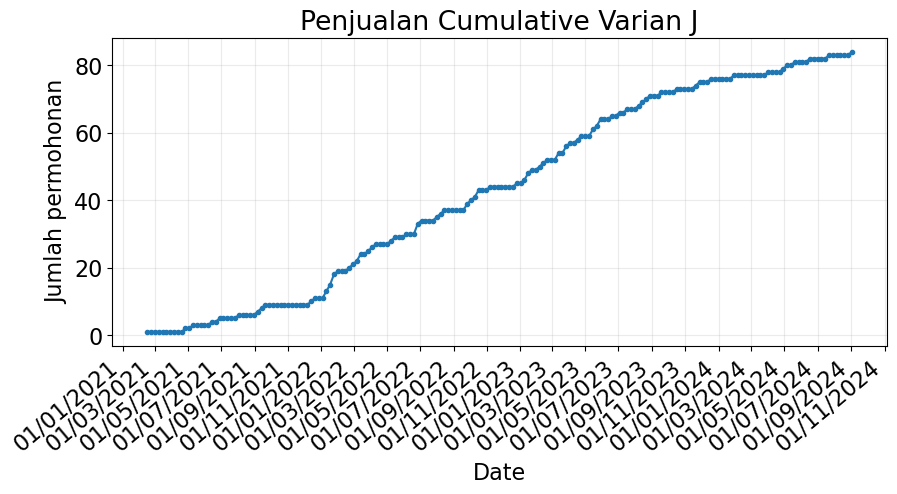

In [10]:
plot_time_series(df_J_weekly["Tgl. Mohon"], df_J_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian J",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [11]:
ADF_result = adfuller(df_J_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.49555796247661876
p-value: 0.8928804193839021


In [12]:
J_diff_week = np.diff(df_J_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(J_diff_week)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -11.22805173397185
p-value: 1.9383015055654662e-20


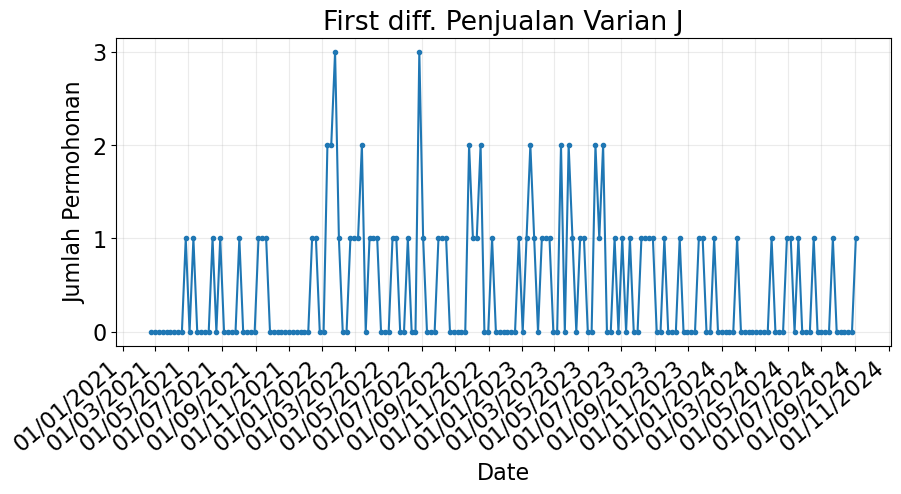

In [13]:
plot_time_series(df_J_weekly["Tgl. Mohon"].iloc[1:], J_diff_week, 
                 title="First diff. Penjualan Varian J",
                 xlabel="Date", ylabel="Jumlah Permohonan")

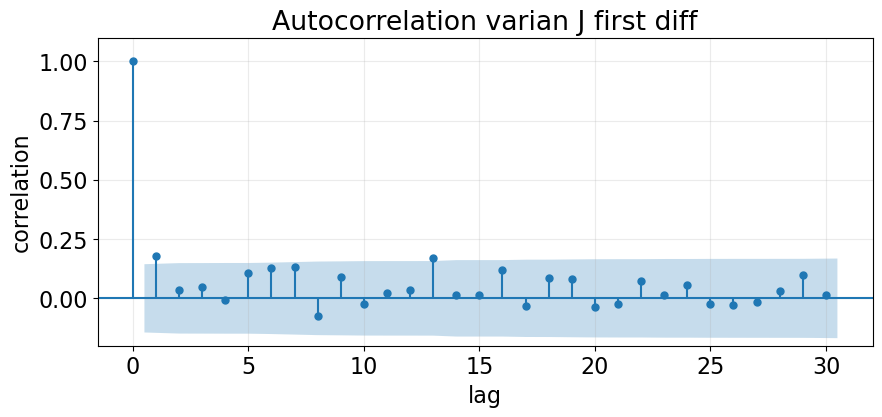

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(J_diff_week, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian J first diff")
ax.grid("on")

plt.show(fig)

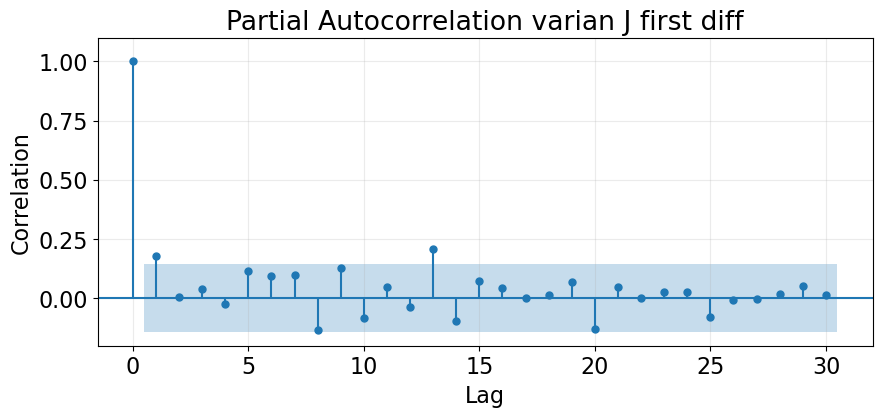

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(J_diff_week, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian J first diff")
ax.grid("on")

plt.show()

### harian

In [16]:
ADF_result = adfuller(df_J_count["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.06806884202784595
p-value: 0.9525275777134233


fisrt diff (_d_=1)

In [17]:
J_diff = np.diff(df_J_count["cumulative_sum"], n=1)
ADF_result = adfuller(J_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -7.048118731522005
p-value: 5.617436477616631e-10


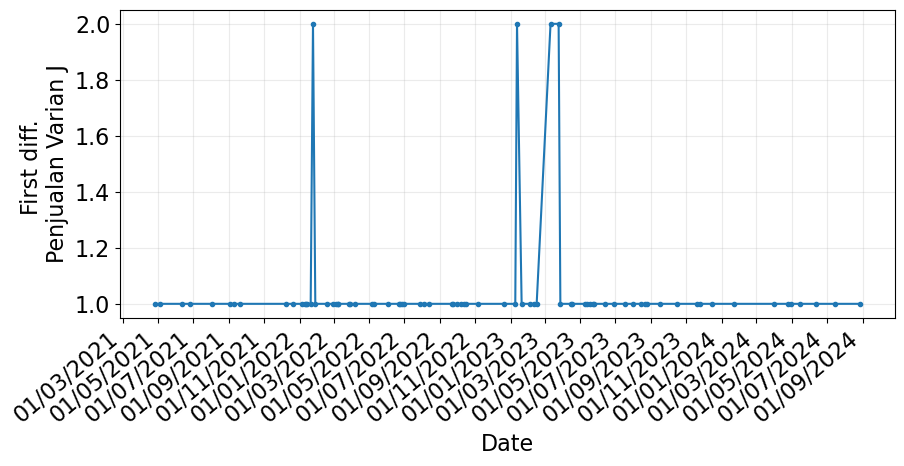

In [18]:
plot_time_series(df_J_count["Tgl. Mohon"].iloc[1:], J_diff, 
                #  title="First diff. Penjualan Varian J",
                 xlabel="Date", ylabel="First diff. \nPenjualan Varian J")

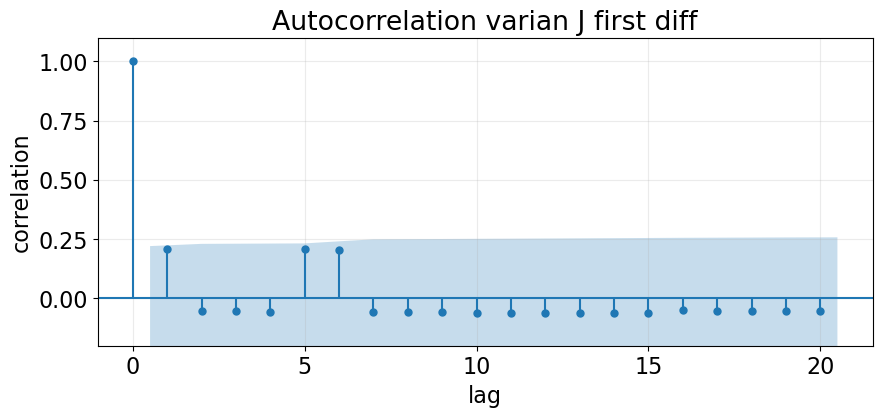

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(J_diff, lags=20, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian J first diff")
ax.grid("on")

plt.show(fig)

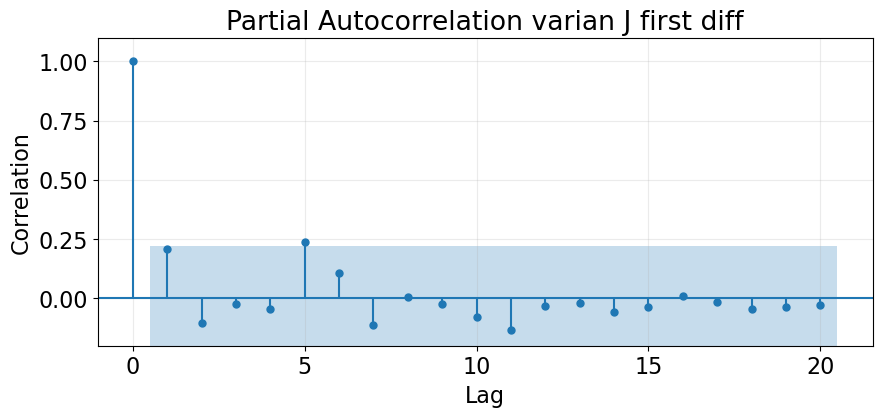

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(J_diff, lags=20, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian J first diff")
ax.grid("on")

plt.show()

gaada lag yang signifikan pada acf dan pacf = random walk

### Data Splitting

In [21]:
min_length = min(len(df_J_count["Tgl. Mohon"].iloc[1:]), len(J_diff))

df_J_diff = pd.DataFrame({
    "Tgl. Mohon": df_J_count["Tgl. Mohon"].iloc[1:min_length+1].values,
    "J_diff": J_diff[:min_length]
})

split_idx = int(0.8 * len(df_J_diff))
df_train = df_J_diff.iloc[:split_idx].copy()
df_test = df_J_diff.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (63, 16)


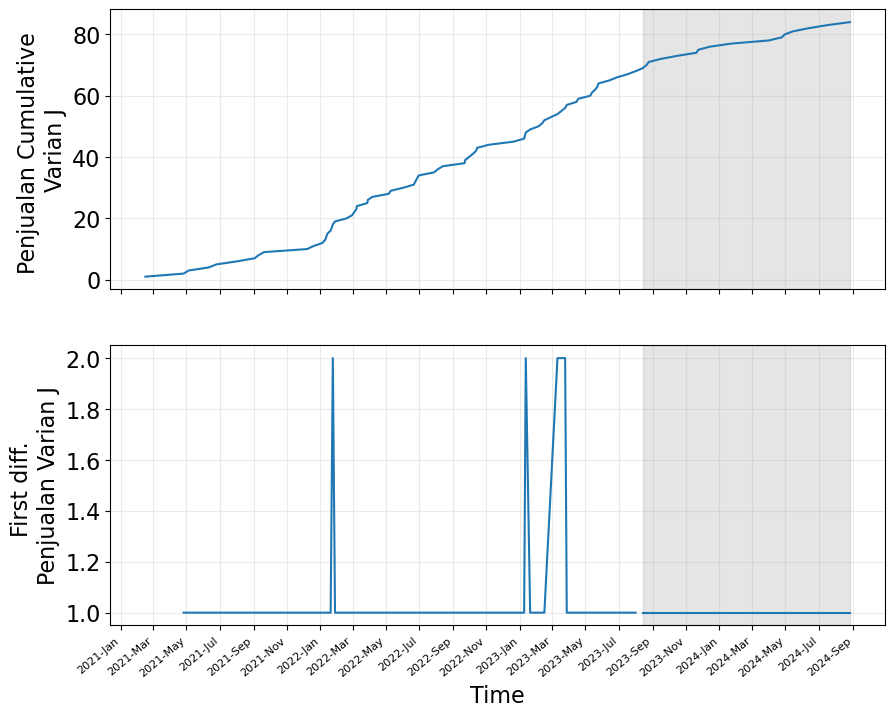

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_J_count["Tgl. Mohon"], df_J_count["cumulative_sum"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan Cumulative \nVarian J")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["J_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["J_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian J")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### Random Walk

Metode $\text{Drift}$ digunakan dalam _time series forecast_ dengan asumsi bahwa perubahan dari waktu ke waktu mengikuti tren linear. Metode ini untuk menangkap tren linier dalam data dan memberikan prediksi yang lebih baik dibandingkan metode rata-rata atau nilai terakhir ketika terdapat pola pertumbuhan atau penurunan yang konsisten. Berikut rumusnya:

$$
  \text{forecast} = \text{drift} \times \text{timestep} + y_i
$$

Keterangan:
- $ y_i $ adalah nilai awal
- $\text{drift}$ menunjukkan perubahan rata-rata per langkah waktu.

Drift dihitung sebagai kemiringan garis yang menghubungkan nilai awal $ y_i $ dengan nilai terakhir dalam data pelatihan $ y_f $:

$$
  \text{drift} = \text{slope} = \frac{h_y}{h_x} = \frac{y_f - y_i}{\text{\# timesteps} - 1}
$$

Dengan:
- $ h_y = y_f - y_i $ sebagai perubahan nilai antara titik awal dan titik akhir.
- $ h_x = \text{timesteps} - 1 $ sebagai selang waktu antara dua titik tersebut.

In [23]:
mean_train_random_walk = np.mean(df_train["J_diff"])
df_test["pred_mean"] = mean_train_random_walk

df_test.head()

,Tgl. Mohon,J_diff,pred_mean
63,2023-08-14,1,1.063492
64,2023-08-21,1,1.063492
65,2023-08-25,1,1.063492
66,2023-09-16,1,1.063492
67,2023-10-16,1,1.063492


In [24]:
last_value = df_train.iloc[-1]["J_diff"]
df_test["pred_last"] = last_value

df_test.head()

,Tgl. Mohon,J_diff,pred_mean,pred_last
63,2023-08-14,1,1.063492,1
64,2023-08-21,1,1.063492,1
65,2023-08-25,1,1.063492,1
66,2023-09-16,1,1.063492,1
67,2023-10-16,1,1.063492,1


In [25]:
h_x = len(df_train) - 1
h_y = last_value - df_train.iloc[0]["J_diff"]
drift = h_y / h_x
print(f"drift = {drift}")

drift = 0.0


In [26]:
x_vals = np.arange(1, len(df_test) + 1)   # x data for test
pred_drift = drift * x_vals + df_train.iloc[0]["J_diff"]
df_test["pred_drift"] = pred_drift

df_test.head()

,Tgl. Mohon,J_diff,pred_mean,pred_last,pred_drift
63,2023-08-14,1,1.063492,1,1.0
64,2023-08-21,1,1.063492,1,1.0
65,2023-08-25,1,1.063492,1,1.0
66,2023-09-16,1,1.063492,1,1.0
67,2023-10-16,1,1.063492,1,1.0


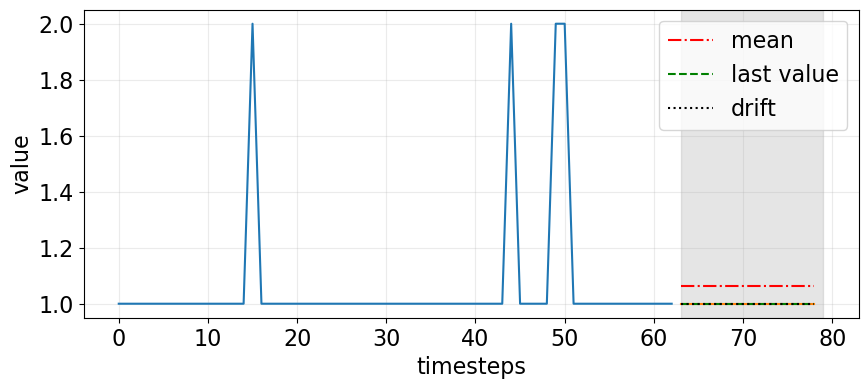

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["J_diff"])
ax.plot(df_test["J_diff"])

# forecasting
ax.plot(df_test["pred_mean"], "r-.", label="mean")
ax.plot(df_test["pred_last"], "g--", label="last value")
ax.plot(df_test["pred_drift"], "k:", label="drift")

# add forecast area (index of `test`)
ax.axvspan(63, 79,
  color="#808080", alpha=0.2
)

ax.grid("on")
ax.set_xlabel("timesteps")
ax.set_ylabel("value")

ax.legend(loc="best")

plt.show(fig)

### Evaluasi

In [28]:
mae_pred_mean   = mean_absolute_error(df_test["J_diff"], df_test["pred_mean"])
mae_pred_last   = mean_absolute_error(df_test["J_diff"], df_test["pred_last"])
mae_pred_drift  = mean_absolute_error(df_test["J_diff"], df_test["pred_drift"])

print(f"MAE mean: {mae_pred_mean}")
print(f"MAE last: {mae_pred_last}")
print(f"MAE drif: {mae_pred_drift}")

MAE mean: 0.06349206349206349
MAE last: 0.0
MAE drif: 0.0


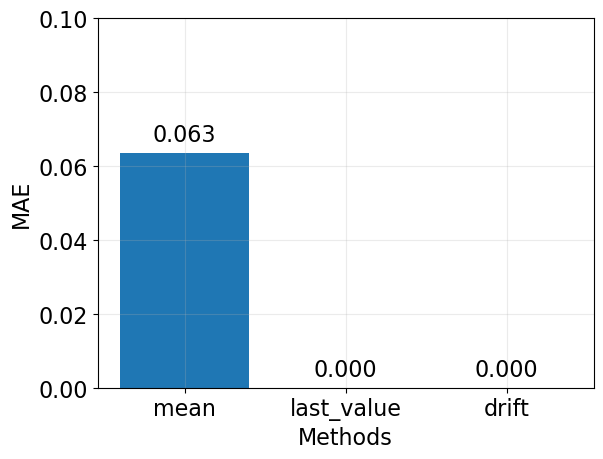

In [29]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mae_pred_mean, mae_pred_last, mae_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 0.1])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [30]:
mse_pred_mean  = mean_squared_error(df_test["J_diff"], df_test["pred_mean"])
mse_pred_last  = mean_squared_error(df_test["J_diff"], df_test["pred_last"])
mse_pred_drift = mean_squared_error(df_test["J_diff"], df_test["pred_drift"])

print(f"MSE mean: {mse_pred_mean}")
print(f"MSE last: {mse_pred_last}")
print(f"MSE drif: {mse_pred_drift}")

MSE mean: 0.004031242126480221
MSE last: 0.0
MSE drif: 0.0


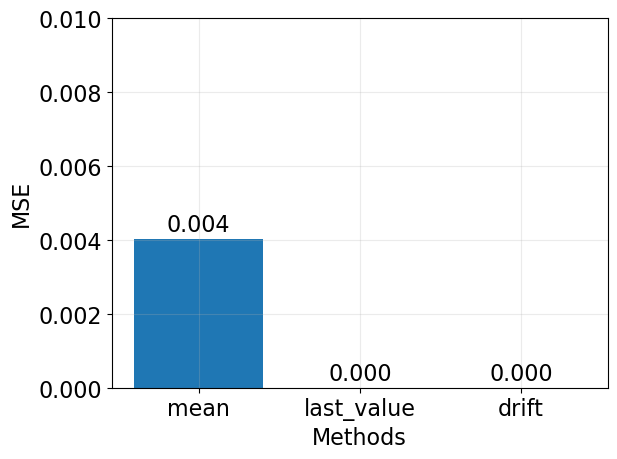

In [31]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mse_pred_mean, mse_pred_last, mse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 0.01])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

RMSE

In [32]:
rmse_pred_mean = np.sqrt(mse_pred_mean)
rmse_pred_last = np.sqrt(mse_pred_last)
rmse_pred_drift= np.sqrt(mse_pred_drift)

print(f"RMSE mean: {rmse_pred_mean}")
print(f"RMSE last: {rmse_pred_last}")
print(f"RMSE drif: {rmse_pred_drift}")

RMSE mean: 0.06349206349206349
RMSE last: 0.0
RMSE drif: 0.0


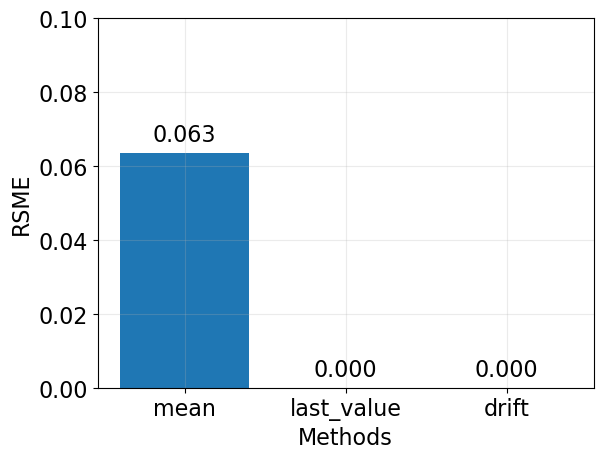

In [33]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [rmse_pred_mean, rmse_pred_last, rmse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RSME")
ax.set_ylim([0, 0.1])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [34]:
mape_pred_mean  = mean_absolute_percentage_error(df_test["J_diff"], df_test["pred_mean"]) * 100 
mape_pred_last  = mean_absolute_percentage_error(df_test["J_diff"], df_test["pred_last"]) * 100
mape_pred_drif  = mean_absolute_percentage_error(df_test["J_diff"], df_test["pred_drift"]) * 100

print(f"MAPE mean: {mape_pred_mean:5.2f}%")
print(f"MAPE last: {mape_pred_last:5.2f}%")
print(f"MAPE drift: {mape_pred_drif:5.2f}%")

MAPE mean:  6.35%
MAPE last:  0.00%
MAPE drift:  0.00%


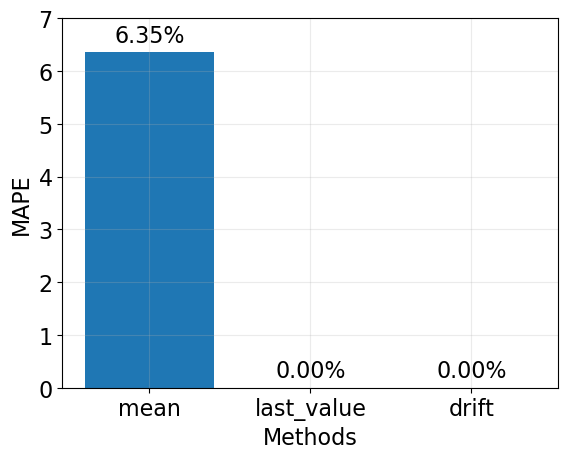

In [35]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mape_pred_mean, mape_pred_last, mape_pred_drif]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 7])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [36]:
naive = np.abs(np.diff(df_train["J_diff"])).mean()

mase_pred_mean = mae_pred_mean / naive
mase_pred_last = mae_pred_last / naive
mase_pred_drift  = mae_pred_drift / naive

print(f"MASE mean: {mase_pred_mean}")
print(f"MASE last: {mase_pred_last}")
print(f"MASE drift: {mase_pred_drift}")

MASE mean: 0.656084656084656
MASE last: 0.0
MASE drift: 0.0


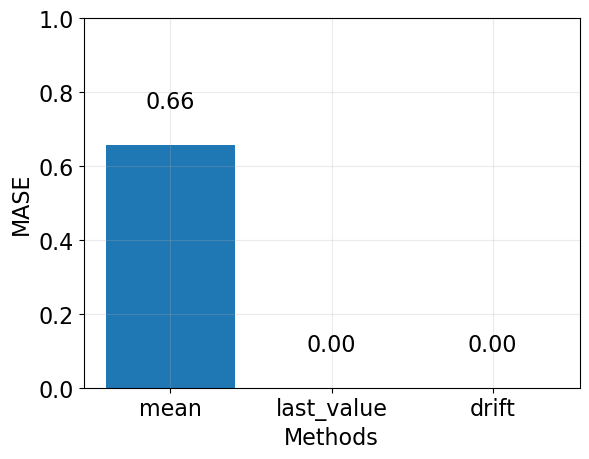

In [37]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mase_pred_mean, mase_pred_last, mase_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 1])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)